In [39]:
from libs.tools import *
from libs.graph_route import plot_graph_route

import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from network.network import Network
#from network.algorithms import eulerian

In [40]:
import numpy as np

__all__ = ["NetworkException", "Network"]


class NetworkException(Exception):
    pass


class Network:
    """Generic framework for network objects.

    Object attributes:
        n (integer): number of nodes
        edges (list): network edges as a list of tuples
        edges_basket (list): node neighbors as list of lists
        degrees_list (list): degrees of each node
        mean_degree (float): average node degree
        k_min (integer): min degree
        k_max (integer): max degree
        degree_distribution (list): degree distribution (or histogram over node degrees)
        degree_bin_edges (list): histogram bin_edges of the degree_distribution

    To use:
        >>> network = Network(3, [(0, 1), (2, 1)])
        >>> network.edges_basket
        [[1], [0, 2], [1]]
        >>> network.degrees_list
        [1, 2, 1]
        >>> network.k_max
        2
        >>> network.k_min
        1
        >>> network.mean_degree
        1.3333333333333333
        >>> network.n
        3

    References:
        .. [1] Newman, M. E. J. (2010),
        Networks: an introduction,
        Oxford University Press, Oxford; New York

        .. [2] Reinhard Diestel,
        Graph Theory,
        Springer, Volume 173 of Graduate texts in mathematics, ISSN 0072-5285
    """

    @staticmethod
    def get_edge_basket(n, edges, edge_basket=None, directed=False, reverse=False, weighted=False):
        """Converts list of edges (tuples) into list of node's neighbors

        Args:
            n (int): number of nodes
            edges (list): list of edges (tuples)
            edge_basket (list): list of node's neighbors
            directed (boolean): if the network is directed
            reverse (boolean): if True will reverse the edges (e.g. (0, 1) to (1, 0))
            weighted (boolean): if the network is weighted

        Returns:
            edge_basket (list): list of node's neighbors
        """
        edges_basket = edge_basket or [[] for _ in range(n)]

        # Removing weights for weighted network
        edges = [(v, u) for v, u, w in edges] if weighted else edges

        for v, u in edges:
            if reverse and directed:
                v, u = u, v

            edges_basket[v].append(u)
            if not directed:
                edges_basket[u].append(v)

        return edges_basket

    def __init__(self, n, edges, edge_basket=None, directed=False, weighted=False):
        self.n = n
        self.directed = directed
        self.weighted = weighted

        # Sanitise weighted edges with no weights, default weight is 1
        if weighted:
            self.edges = [e for e in edges if len(e) == 3]
            self.edges.extend([(e[0], e[1], 1) for e in edges if len(e) == 2])
        else:
            self.edges = edges

        self.edges_basket = edge_basket or self.get_edge_basket(n, self.edges, directed=directed, weighted=weighted)

        self.degrees_list = [len(_) for _ in self.edges_basket]

        self.mean_degree = np.mean(self.degrees_list)  # TODO: think about powerlaw
        self.k_min = min(self.degrees_list) if n > 0 else 0
        self.k_max = max(self.degrees_list) if n > 0 else 0

    def get_degree_distribution(self, log=False, density=True):  # TODO: think about powerlaw
        """Determines the network's degree distribution on both linear or logarithmic scale

        Args:
            log (boolean): Using the logarithmic scale
            density (boolean): Returning distribution over the cumulative values (histogram)

        Returns:
            degree_distribution (list): degree distribution (or histogram over node degrees)
            degree_bin_edges (list): histogram bin_edges of the degree_distribution

        Usage:
            >>> network = Network(3, [(0, 1), (2, 1)])
            >>> network.get_degree_distribution()
            (array([0.66666667, 0.33333333]), array([1, 2]))
            >>> network.degree_distribution
            array([0.66666667, 0.33333333])

        Warning:
            degree_distribution and degree_bin_edges are not in Network.__init__, they are intentionally determined
            after running Network.get_degree_distribution()!

        """
        m_log = np.round(np.log10(self.k_max), 0)

        bins = np.logspace(np.log10(self.k_min), np.log10(10. ** m_log), m_log * 5.) if log \
            else np.arange(1, self.k_max + 2)

        degree_distribution, bin_edges = np.histogram(self.degrees_list, bins=bins, density=density)

        self.degree_distribution = degree_distribution
        self.degree_bin_edges = bin_edges[:-1]

        return degree_distribution, bin_edges[:-1]

    def directed_degrees(self):
        """However, degrees_list holds info about out-degree values (or both for undirected networks), this function
        return out-degree and in-degree for each node

        Returns:
            (tuple): a tuple of two lists denoting out-degree and in-degree

        Warning:
            in_degrees_list, in_k_min and in_k_max are not in Network.__init__, they are intentionally determined
            after running Network.directed_degrees()!
        """
        out_degree = self.degrees_list
        in_coming_edges_basket = self.get_edge_basket(self.n, self.edges, reverse=True, directed=True)

        in_degree = [len(_) for _ in in_coming_edges_basket]
        self.in_degrees_list = in_degree
        self.in_k_min = min(in_degree) if self.n > 0 else 0
        self.in_k_max = max(in_degree) if self.n > 0 else 0

        return out_degree, in_degree

In [41]:
#from network.network import NetworkException


class NotEulerianNetwork(NetworkException):
    pass


class NotNetworkNode(NetworkException):
    pass


class SourceTargetNotConnected(NetworkException):
    pass


class NetworkIsNotBipartite(NetworkException):
    pass


In [42]:
#from network.network import Network
#from network.algorithms.exceptions import NotEulerianNetwork, NotNetworkNode
from copy import deepcopy

# A connected graph has an Euler cycle if and only if every vertex has even degree.
# ~ Euler

__all__ = ["is_eulerian", "hierholzer"]


def is_eulerian(network: Network):
    """ Checks if the network is Eulerian

    Args:
        network (Network): network object

    returns
        is_eulerian (boolean): True if every vertex has even degree.
        odd_degree_nodes (list): list if nodes with odd degree
    """
    if network.directed:
        out_degree, in_degree = network.directed_degrees()
        odd_degree_nodes = [
            {"node": n, "out_degree": d, "in_degree": in_degree[n]}
            for n, d in enumerate(out_degree) if d != in_degree[n]
        ]
    else:
        odd_degree_nodes = [{"node": n, "degree": d} for n, d in enumerate(network.degrees_list) if d % 2 == 1]

    return len(odd_degree_nodes) == 0, odd_degree_nodes


def hierholzer(network: Network, source=0):
    """ Hierholzer's algorithm for finding an Euler cycle

    Args:
        network (Network): network object
        source(int): node where starts (and ends) the path

    Raises:
        NotEulerianNetwork: if exists at least one node with odd degree
        NotNetworkNode: if source is not in the network

    Returns:
        list of nodes that form a path visiting all edges

    References:
        .. [1] sanjeev2552, heruslu, Code_Mech,
        Geeks For Geeks, A computer science portal for geeks
        https://www.geeksforgeeks.org/hierholzers-algorithm-directed-graph/

        .. [2] Reinhard Diestel,
        Graph Theory,
        Springer, Volume 173 of Graduate texts in mathematics, ISSN 0072-5285
    """

    if source > network.n:
        raise NotNetworkNode(f"Source node {source} is not in the network (N={network.n})")

    path = []
    temp_path = []
    degrees_list = deepcopy(network.degrees_list)
    edges_basket = deepcopy(network.edges_basket)
    if network.n == 0:
        return path

    eulerian, odd_degree_nodes = is_eulerian(network)
    if not eulerian:
        raise NotEulerianNetwork(f"Network is not Eulerian, not all nodes are even degree: {odd_degree_nodes}")

    temp_path.append(source)
    temp_node = source

    while len(temp_path):
        if degrees_list[temp_node]:
            temp_path.append(temp_node)
            next_node = edges_basket[temp_node][-1]

            degrees_list[temp_node] -= 1
            edges_basket[temp_node].pop()

            if not network.directed:
                degrees_list[next_node] -= 1
                i = edges_basket[next_node].index(temp_node)
                del edges_basket[next_node][i]

            temp_node = next_node
        else:
            path.append(temp_node)
            temp_node = temp_path[-1]
            temp_path.pop()

    # If the network is directed we will revert the path
    if network.directed:
        return path[::-1]

    return path

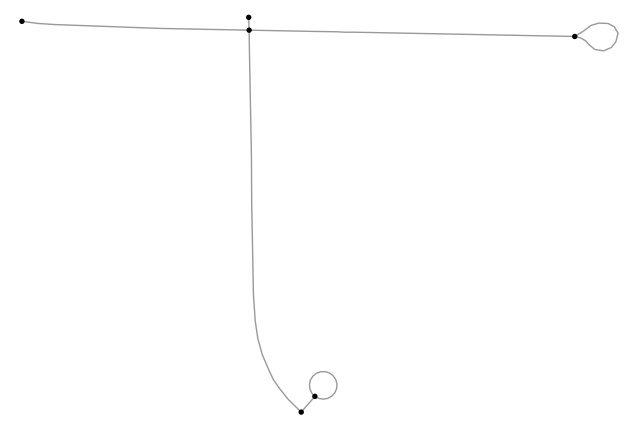

In [74]:
CUSTOM_FILTER = (
    '["highway"]["area"!~"yes"]["highway"!~"bridleway|bus_guideway|bus_stop|construction|'
    'cycleway|elevator|footway|motorway|motorway_junction|motorway_link|escalator|proposed|'
    'construction|platform|raceway|rest_area|path|service"]["access"!~"customers|no|private"]'
    '["public_transport"!~"platform"]["fee"!~"yes"]["foot"!~"no"]["service"!~"drive-through|'
    'driveway|parking_aisle"]["toll"!~"yes"]'
)

location = "University, Las Vegas, Nevada, USA"
org_graph = ox.graph_from_place(location, custom_filter=CUSTOM_FILTER)

""" Simplifying the original directed multi-graph to undirected, so we can go both 
    ways in one way streets """
graph = ox.utils_graph.get_undirected(org_graph)
fig, ax = ox.plot_graph(graph, node_zorder=2, node_color="k", bgcolor="w")

In [22]:
# Finds the odd degree nodes and minimal matching
odd_degree_nodes = get_odd_degree_nodes(graph)
pair_weights = get_shortest_distance_for_odd_degrees(graph, odd_degree_nodes)
matched_edges_with_weights = min_matching(pair_weights)

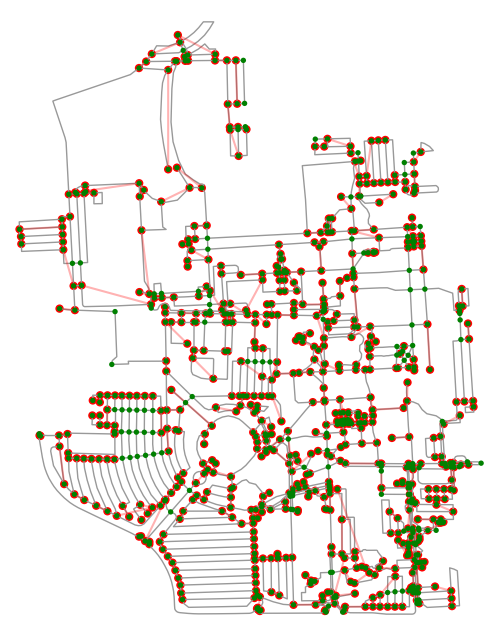

In [23]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='black', frameon=False)
for v, u, w in matched_edges_with_weights:
    x = graph.nodes[v]["x"], graph.nodes[u]["x"]
    y = graph.nodes[v]["y"], graph.nodes[u]["y"]
    ax.plot(x, y, c='red', alpha=0.3)
    ax.scatter(x, y, c='red', edgecolor="none")

fig, ax = ox.plot_graph(graph, node_zorder=2, node_color='g', bgcolor='k', ax=ax)

In [52]:
# List all edges of the extended graph including original edges and edges from minimal matching
single_edges = [(u, v) for u, v, k in graph.edges]
added_edges = get_shortest_paths(graph, matched_edges_with_weights)
edges = map_osmnx_edges2integers(graph, single_edges + added_edges)

# Finds the Eulerian path
network_test = Network(len(graph.nodes), edges)#, weighted=True)



In [44]:
network_test.directed

False

In [45]:
eulerian_path = hierholzer(network_test)
converted_eulerian_path = convert_integer_path2osmnx_nodes(eulerian_path, graph.nodes())
double_edge_heap = get_double_edge_heap(org_graph)

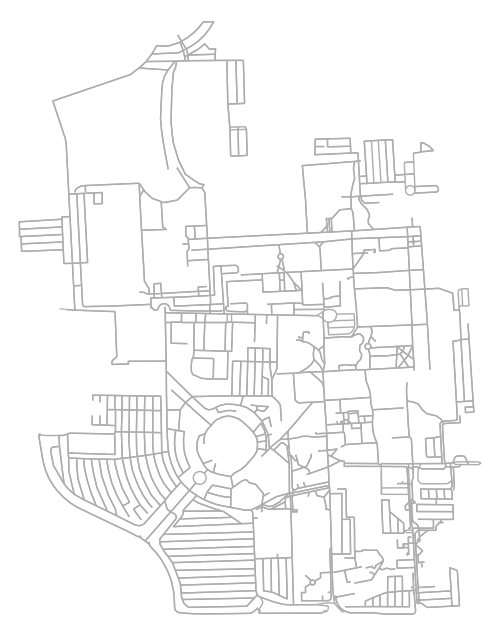

In [47]:

# Finds the final path with edge IDs
final_path = convert_path(graph, converted_eulerian_path, double_edge_heap)

fig, ax = plot_graph_route(org_graph, final_path, route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2, route_color="w")

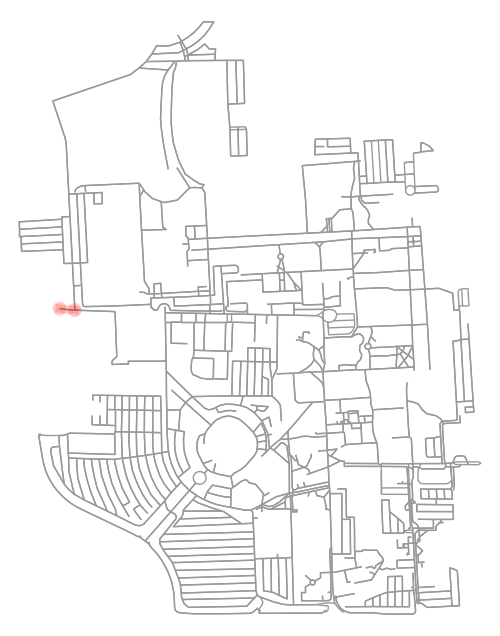

OSError: [Errno 30] Read-only file system: '/img_1.png'

In [62]:
for i, e in enumerate(final_path, start=1):
    fig, ax = plot_graph_route(org_graph, final_path[:i], route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2)
    ax.set_title(location)
    fig.savefig(f"/img_{i}.png", dpi=120, bbox_inches="tight")

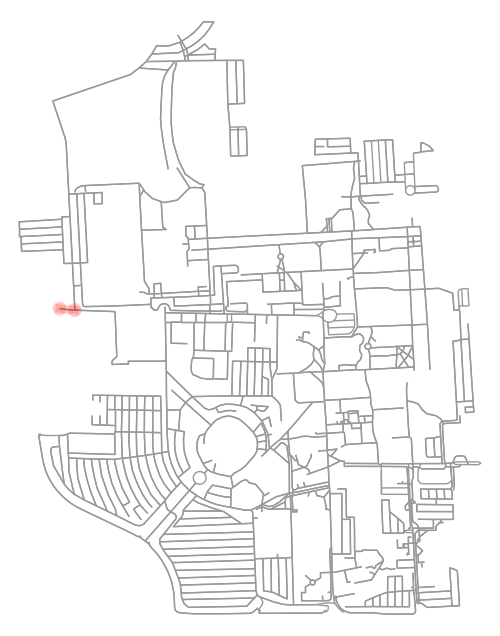

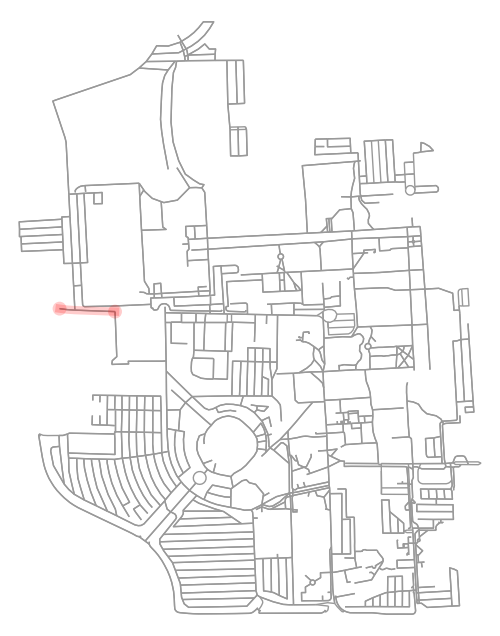

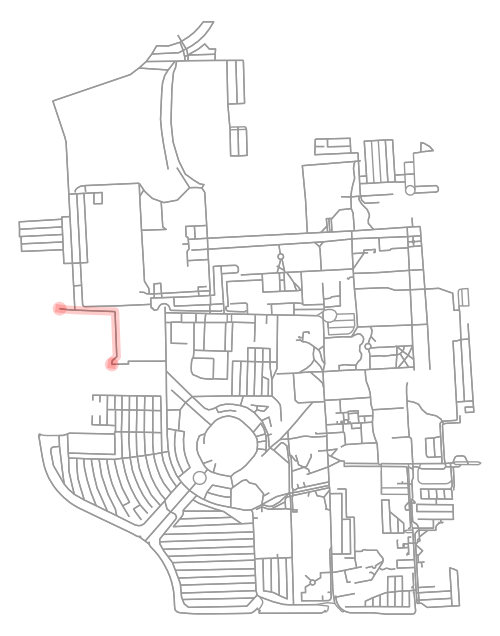

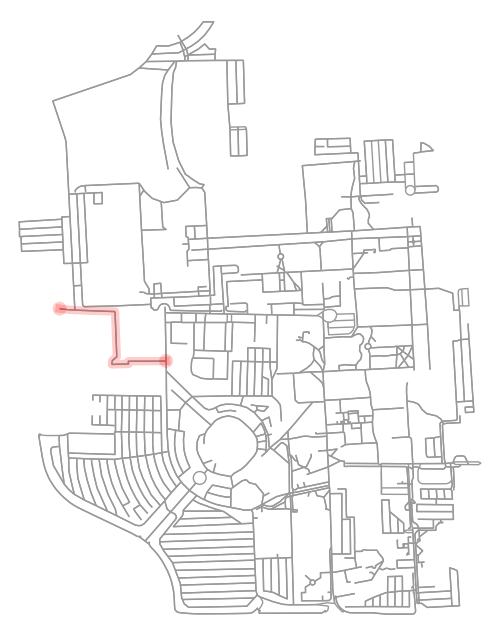

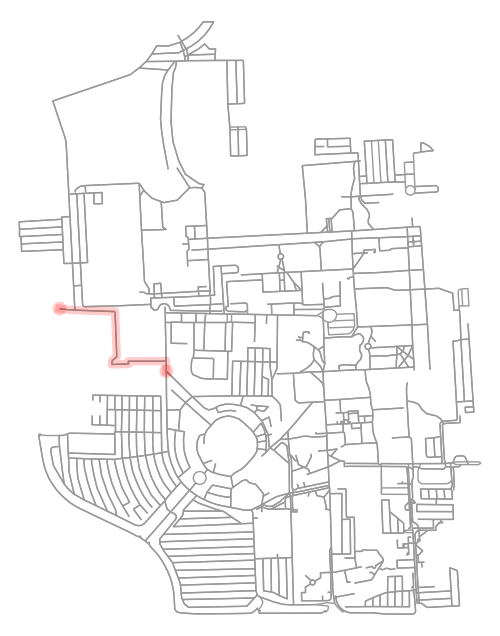

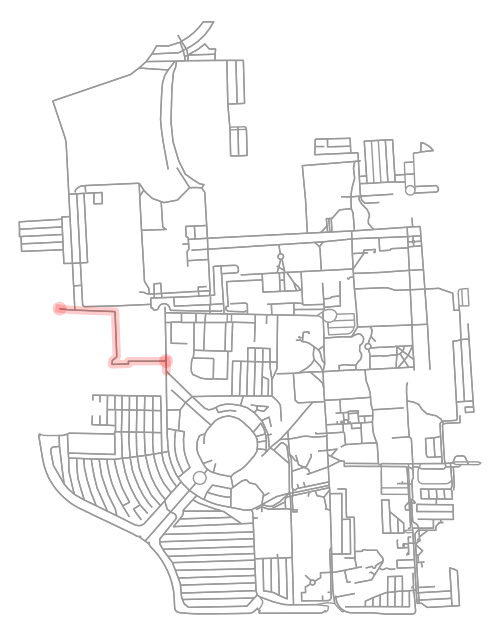

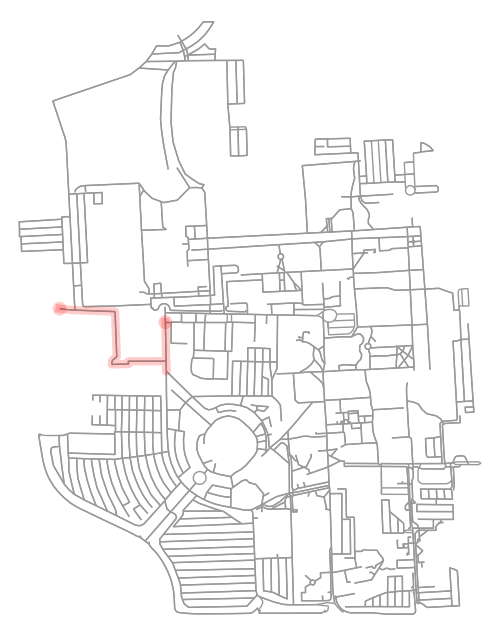

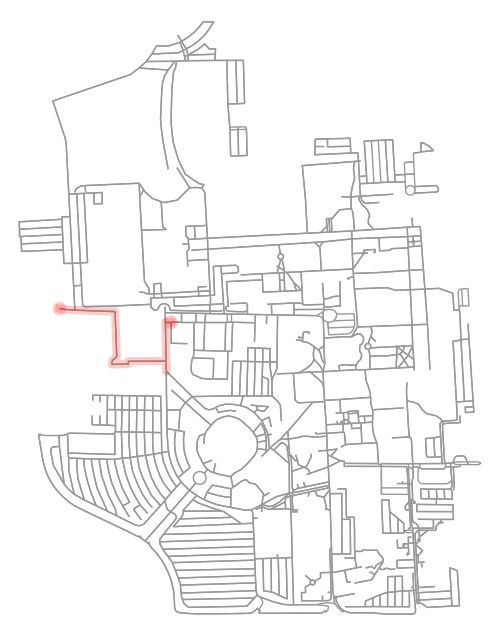

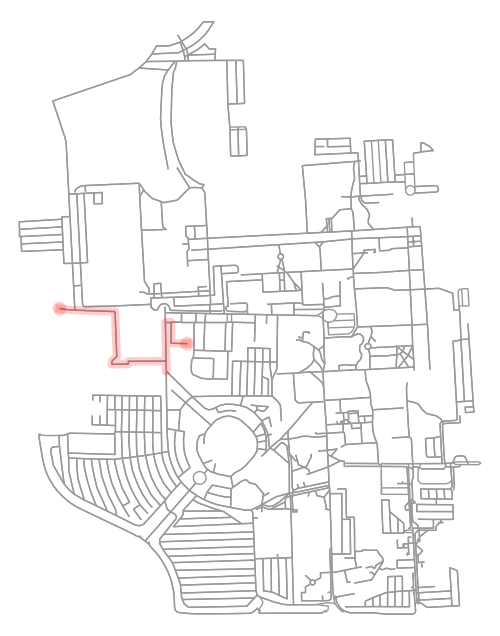

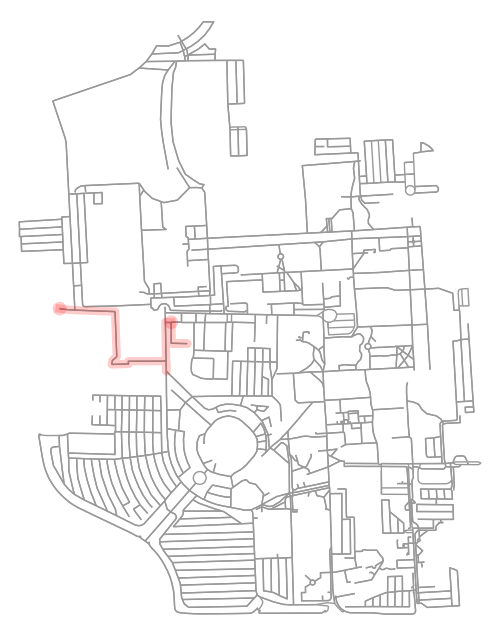

In [73]:
# Create the frames
frames = []
for i, e in enumerate(final_path, start=1):
    if i <= 10:
        plot_graph_route(org_graph, final_path[:i], route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2)[0].savefig(f"mb_cache/img_{i}.png", dpi=120, bbox_inches="tight")
    else:
        break

for i in range(1, 10):
    new_frame = Image.open(f"mb_cache/img_{i}.png")
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('mb_cache/png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

In [70]:
frames[0].savefig('mb_cache/test.png')

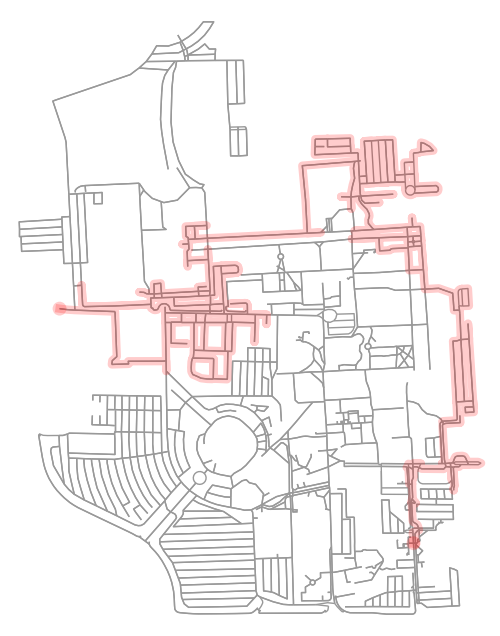

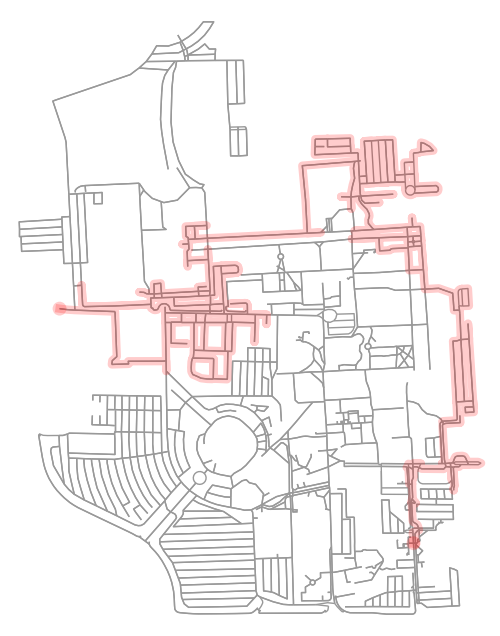

In [65]:
plot_graph_route(org_graph, final_path[:i], route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2)[0]

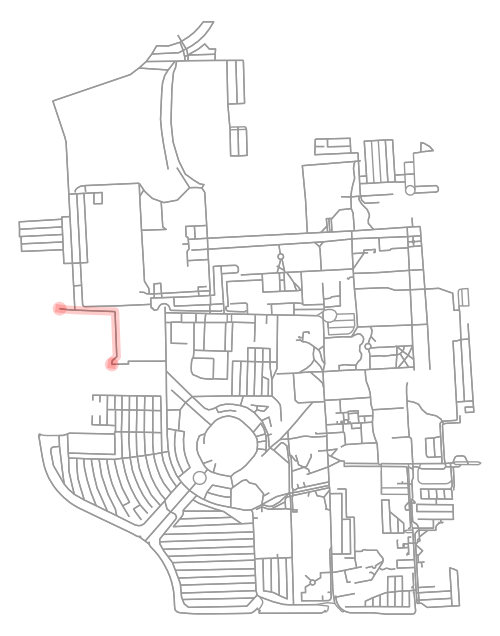

OSError: [Errno 30] Read-only file system: '/img_1.png'

In [59]:
fig, ax = plot_graph_route(org_graph, final_path[:3], route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2)
ax.set_title(location)
fig.savefig(f"/img_{i}.png", dpi=120, bbox_inches="tight")

In [54]:
final_path

[(137295156, 137295158, 0),
 (137295158, 9072807374, 0),
 (9072807374, 9072807378, 0),
 (9072807378, 7045484639, 0),
 (7045484639, 1710460895, 0),
 (1710460895, 7045484639, 0),
 (7045484639, 2488907629, 0),
 (2488907629, 5509252781, 0),
 (5509252781, 5509252779, 0),
 (5509252779, 5509252781, 0),
 (5509252781, 2488907629, 0),
 (2488907629, 1428432262, 0),
 (1428432262, 1428432253, 0),
 (1428432253, 1428432262, 0),
 (1428432262, 3324567734, 0),
 (3324567734, 2488907633, 0),
 (2488907633, 3324567734, 0),
 (3324567734, 3324567735, 0),
 (3324567735, 5509252781, 0),
 (5509252781, 3324567735, 0),
 (3324567735, 3348428578, 0),
 (3348428578, 2488907634, 0),
 (2488907634, 3348428578, 0),
 (3348428578, 2488907635, 0),
 (2488907635, 2488907632, 0),
 (2488907632, 2488907635, 0),
 (2488907635, 7477475768, 0),
 (7477475768, 7477475765, 1),
 (7477475765, 7477475768, 0),
 (7477475768, 7477475765, 0),
 (7477475765, 7477475772, 0),
 (7477475772, 2488907637, 0),
 (2488907637, 7477475772, 0),
 (7477475772,